Autores: Alexandre Liermann, Gustavo Guerreiro e João Martinho.

# Implementação de Classificação de Imagens de Ressonância Magnética para Diagnóstico de Alzheimer Usando CNN em TensorFlow

Importações das bibliotecas necessárias

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import pathlib

In [2]:
def configurar_gpu():
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")

Definindo os diretórios do dataset

In [3]:
img_height = 176
img_width  = 208
batch_size = 32

dir_dados = pathlib.Path('dataset')
dataset_completo = tf.keras.utils.image_dataset_from_directory(
    dir_dados,
    seed=42,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=None
)

def separar_dataset(ds, train_split=0.7, val_split=0.15):
    ds = ds.shuffle(10000, seed=12)

    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    val_size   = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)

    return (
        train_ds.batch(batch_size),
        val_ds.batch(batch_size),
        test_ds.batch(batch_size)
    )

dataset_treino, dataset_val, dataset_teste = separar_dataset(dataset_completo)


Found 6400 files belonging to 4 classes.


I0000 00:00:1763612902.646264   21857 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
from tensorflow.data import AUTOTUNE

dataset_treino = dataset_treino.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val    = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)
dataset_teste  = dataset_teste.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets prontos!")
print(f"Batches de Treino: {len(dataset_treino)}")
print(f"Batches de Validação: {len(dataset_val)}")
print(f"Batches de Teste: {len(dataset_teste)}")

Datasets prontos!
Batches de Treino: 140
Batches de Validação: 30
Batches de Teste: 30


In [5]:

def normalizar_img(imagem, rotulo):
    imagem = tf.cast(imagem, tf.float32) / 255.0
    return imagem, rotulo

# 🔴 NÃO use mais isolar_luminancia aqui
dataset_treino = dataset_treino.map(normalizar_img)
dataset_val    = dataset_val   .map(normalizar_img)
dataset_teste  = dataset_teste .map(normalizar_img)


Isolando luminância.

In [6]:
def isolar_luminancia(imagem, rotulo):
    imagem = tf.image.rgb_to_grayscale(imagem)
    return imagem, rotulo

dataset_treino = dataset_treino.map(isolar_luminancia)
dataset_val = dataset_val.map(isolar_luminancia)
dataset_teste = dataset_teste.map(isolar_luminancia)

Iniciando a configuração do modelo.

In [7]:
import gc
from tensorflow.keras import models, layers

tf.keras.backend.clear_session()
gc.collect()

modelo = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

/home/guto/cats_dogs/aprendizado_de_maquina/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilando o modelo com a definição de otimizador (Adaptive Moment Estimation), perda e métricas.

In [8]:
modelo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Definindo callback de EarlyStopping.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

Treinando o modelo

In [10]:
history = modelo.fit(
    dataset_treino,
    validation_data=dataset_val,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1763612918.432424   21921 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.4975 - loss: 1.0722 - val_accuracy: 0.5781 - val_loss: 0.8930
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5920 - loss: 0.8831 - val_accuracy: 0.6208 - val_loss: 0.8167
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6589 - loss: 0.7551 - val_accuracy: 0.7240 - val_loss: 0.6255
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7511 - loss: 0.5764 - val_accuracy: 0.8396 - val_loss: 0.4276
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8355 - loss: 0.3896 - val_accuracy: 0.9031 - val_loss: 0.2801
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8906 - loss: 0.2697 - val_accuracy: 0.9542 - val_loss: 0.1732
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9350 - loss: 0.1762 - val_accuracy: 0.9802 - val_loss: 0.0991
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9638 - loss: 0.1022 - val_accuracy: 0.98

Métricas mais avançadas com sklearn

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

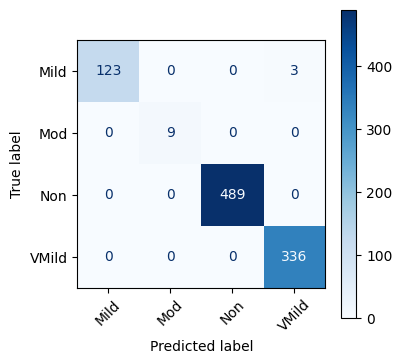

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from matplotlib import pyplot as plt

y_verdadeiro = []
y_previsto = []

for imagens, rotulos in dataset_teste:
    previsoes = modelo.predict(imagens)
    y_verdadeiro.extend(rotulos.numpy())
    y_previsto.extend(np.argmax(previsoes, axis=1))


classes = ['Mild', 'Mod', 'Non', 'VMild']

print("Relatório de Classificação:\n")
print(classification_report(y_verdadeiro, y_previsto, target_names=classes))

cm = confusion_matrix(y_verdadeiro, y_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(xticks_rotation=45, cmap='Blues', ax=ax)
plt.show()

In [12]:
ARQUIVO_MODELO = ('alzheimer_previsao.keras')

modelo.save(ARQUIVO_MODELO)